# Usage

We will demonstrate an example of the `sainsc` workflow using the Stereo-seq Mouse Embryo E16.5 (E1S3) from the original [Stereo-seq publication](https://www.sciencedirect.com/science/article/pii/S0092867422003993).

The Stereo-seq dataset used in this analysis is available at [https://db.cngb.org/stomics/mosta](https://db.cngb.org/stomics/mosta).

To follow along make sure you installed `sainsc` with the 'data' extra (``pip install sainsc[data]``) and the `scanpy`, `squidpy`, and `colorcet` package.

First we need to load some essential packages and define the input file we are going to use.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from sainsc.io import read_StereoSeq

In [2]:
# location of the Stereo-seq data
stereo_seq_file = Path("path/to/stereoseq/data") / "E16.5_E1S3_GEM_bin1.tsv.gz"

## Load and prepare data

First we are going to load the Stereo-seq data from the GEM file.

In [3]:
embryo = read_StereoSeq(stereo_seq_file)

print(embryo)

LazyKDE (32 threads)
    genes: 28633
    shape: (44100, 26460)
    resolution: 500.0 nm / px


First, we want to get a quick overview of what our sample looks like.

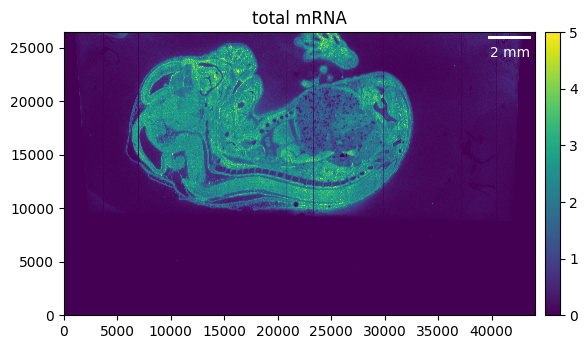

In [4]:
embryo.calculate_total_mRNA()

_ = embryo.plot_genecount(im_kwargs={"vmax": 5})

### Selecting the region of interest

We can see that the region of interest in our case is much smaller than the total area of our sample. Cropping and masking helps to focus only on the relevant parts of our tissue, and on top will reduce memory usage and processing time.

So as a first step we can crop away the parts of the tissue that we don't need. Make sure to recalculate the total mRNA as otherwise the previously calculated counts will be shown.

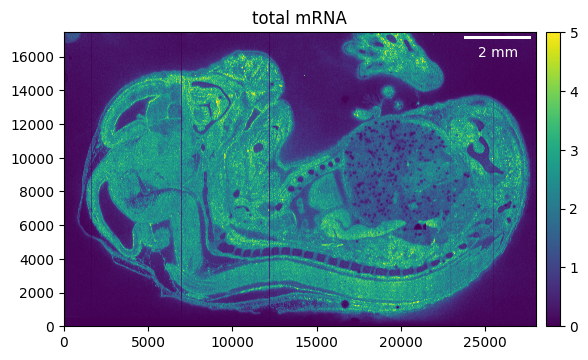

In [5]:
embryo.counts.crop((5_000, 33_000), (9_000, None))

embryo.calculate_total_mRNA()

_ = embryo.plot_genecount(im_kwargs={"vmax": 5})

If we want to go even further we can "mask" the region of interest. For example, we can export the count array and use it to manually draw a selection mask.

In [6]:
from PIL import Image

# export total mRNA as png
u8 = np.uint8
Image.fromarray(
    np.clip(embryo.total_mRNA, np.iinfo(u8).min, np.iinfo(u8).max).astype(u8)
).save("embryo_counts.png")

This is what are region of interest (ROI) looks like after manually drawing the outline ...

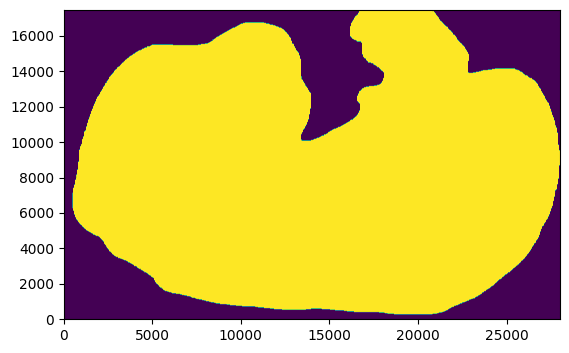

In [7]:
import matplotlib.pyplot as plt

from sainsc.datasets import fetch_embryo_mask

# avoid the DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

mask_file = fetch_embryo_mask()
embryo_mask = np.array(Image.open(mask_file), dtype=bool)

_ = plt.imshow(embryo_mask.T, origin="lower")

Using it to filter the counts is easy, just make sure that the shapes of the mask and the sample are the same.

In [8]:
embryo.counts.filter_mask(embryo_mask)

We can filter the genes that have no counts left after cropping and masking.

In [9]:
embryo.counts.filter_genes_by_count(1)

Let's check the result.

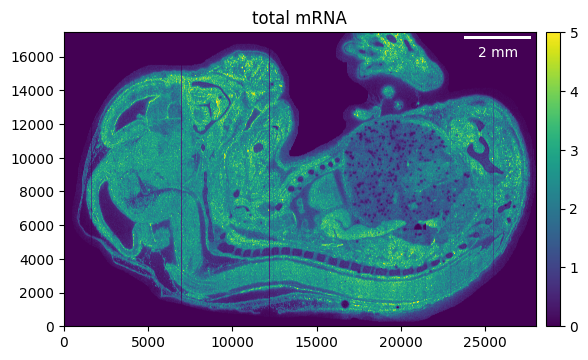

In [10]:
embryo.calculate_total_mRNA()

_ = embryo.plot_genecount(im_kwargs={"vmax": 5})

We can visualize the number of counts per gene as a histogram to get a quick overview of the distribution.

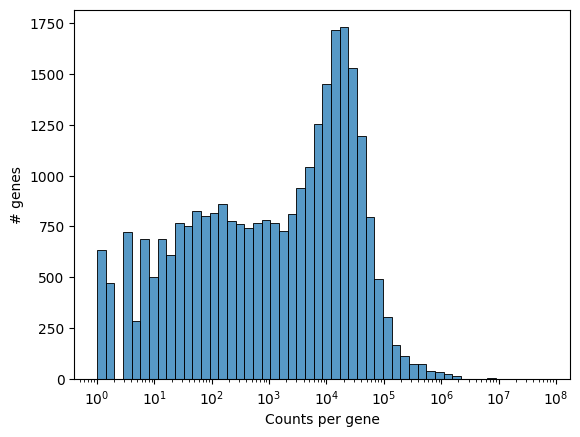

In [11]:
_ = embryo.plot_genecount_histogram()

Additional functionality like filtering the genes by counts, or selecting genes by names are available for [`sainsc.GridCounts`](#sainsc.GridCounts).

## KDE

To estimate the kernel density we first need to define a kernel. This can easily be done using the [`sainsc.LazyKDE.gaussian_kernel`](#sainsc.LazyKDE.gaussian_kernel) method, allowing us to either specify the bandwidth in pixels or um. Generally, we found ~ 4 um to work for most samples.

Except for the total mRNA, the KDE is not stored but rather calculated whenever it is needed (e.g. for plotting or assigning cell types).

In [12]:
embryo.gaussian_kernel(4, unit="um")

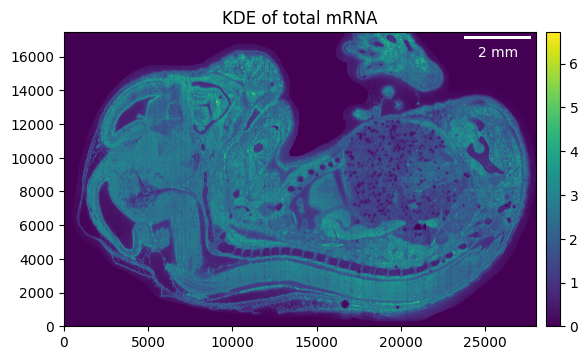

In [13]:
embryo.calculate_total_mRNA_KDE()

_ = embryo.plot_KDE()

### Filtering background

The histogram of the total mRNA KDE can be useful to define which areas are likely to be background (i.e. empty, noisy areas).

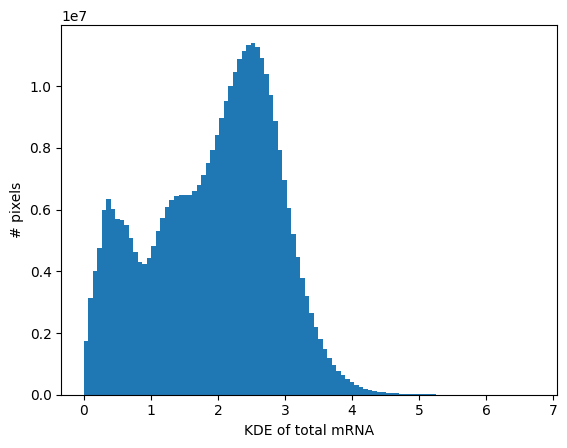

In [14]:
_ = embryo.plot_KDE_histogram(bins=100)

Here we will use a rough estimation of 0.9, but will later make use of the fact that we can also filter the background with a threshold per cell type.

Background will not be removed so data will not be overwritten to avoid recomputation. Rather corresponding values are set to 0 when plotting or similar.

In [15]:
embryo.filter_background(0.9)

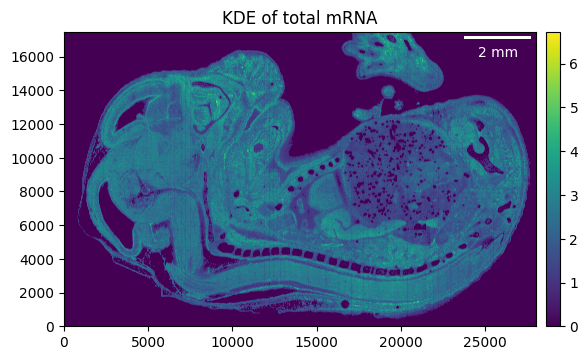

In [16]:
_ = embryo.plot_KDE(remove_background=True)

## Cell-type assignment

All we need to assign a cell type to every pixel of our sample is a kernel, which we previously already defined, and a set of gene expression signatures.

The gene expression signatures can be based on prior knowledge (e.g. scRNAseq experiments) or can be computed *de novo* which we will demonstrate later.

### Known signatures

Here, our signatures are pre-computed already and based on the segmented data published in the original Stereo-seq publication by [Chen *et al* 2022](https://www.sciencedirect.com/science/article/pii/S0092867422003993) using the [`sainsc.utils.celltype_signatures`](#sainsc.utils.celltype_signatures) function.

In [17]:
from sainsc.datasets import fetch_embryo_signatures

signatures = fetch_embryo_signatures()
signatures.iloc[:, :4].head()

,Cardiomyocyte,Chondrocyte,Choroid plexus,Dorsal midbrain neuron
gene,,,,
1110017D15Rik,0.000022,0.000039,0.001147,0.000077
1110035H17Rik,0.000003,0.000002,0.000000,0.000010
1190001M18Rik,0.000002,0.000003,0.000000,0.000005
1300014J16Rik,0.000003,0.000005,0.000000,0.000004
1500015O10Rik,0.000069,0.000884,0.003061,0.000075


Now we can assign the cell type. This is usually the most computationally expensive step.

In [18]:
embryo.assign_celltype(signatures)

print(embryo)

LazyKDE (32 threads)
    genes: 28558
    shape: (28000, 17460)
    resolution: 500.0 nm / px
    kernel: (33, 33)
    background: set
    celltypes: 25


Visualizing the cell-type map is straightforward. You can use a custom color-mapping for the cell types as well.

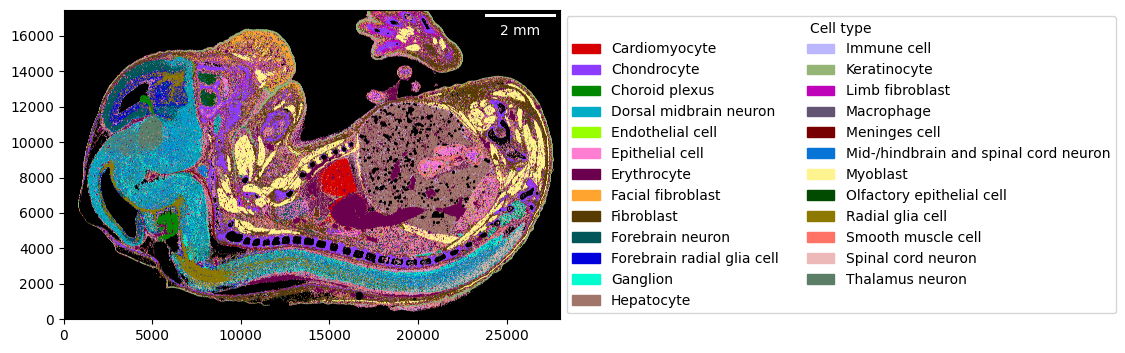

In [19]:
import colorcet as cc
import seaborn as sns

cmap = dict(
    zip(embryo.celltypes, sns.color_palette(cc.glasbey, n_colors=len(embryo.celltypes)))
)

_ = embryo.plot_celltype_map(cmap=cmap)

As most plotting functions, it also allows "zooming" into regions more closely. 

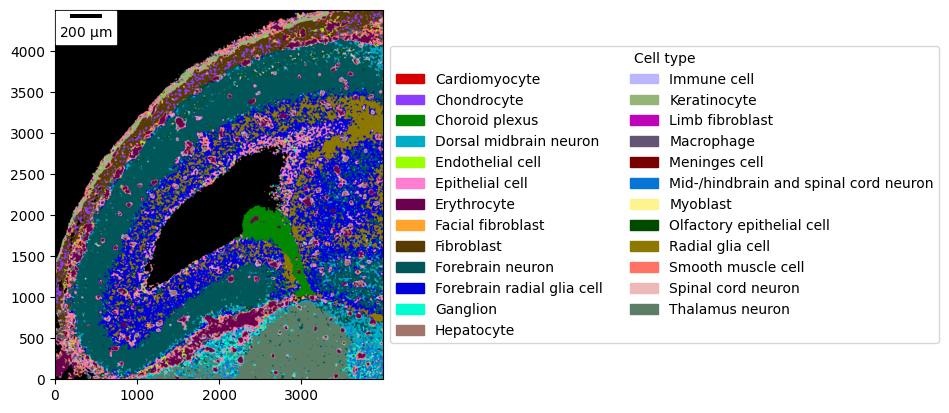

In [20]:
_ = embryo.plot_celltype_map(
    crop=((2_000, 6_000), (10_500, 15_000)),
    cmap=cmap,
    scalebar_kwargs={"location": "upper left"},
)

The assignment score is helpful to identify regions that have been assigned with high confidence, vs regions with low confidence. Please refer to the `sainsc` publication for details.

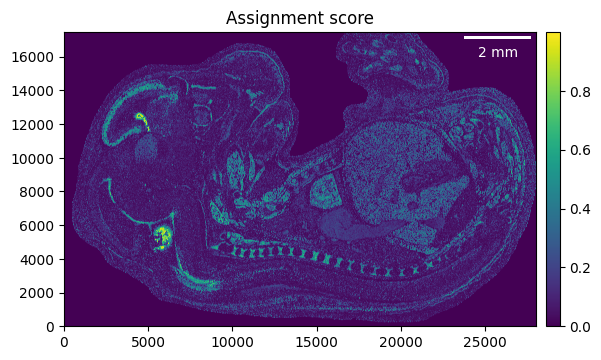

In [21]:
_ = embryo.plot_assignment_score()

### *De novo* cell-type signatures

To generate a cell-type map without prior knowledge of the cell types or their expression profiles, we can use expression signatures that we generate from the data directly.

Briefly, we identify local maxima of the gene expression as proxies for cells. We load the KDE of these cell proxies and use it to cluster the data following standard single-cell RNA sequencing workflows. Using the expression of the extracted clusters, we can generate the cell-type map.

First off, we need to identify the local maxima. We only need to specify the minimum distance between two maxima, but it can be helpful to filter the background and only identify maxima in connected regions of a minimum size.

In [22]:
embryo.find_local_maxima(4, min_area=60)

print(embryo)

LazyKDE (32 threads)
    genes: 28558
    shape: (28000, 17460)
    resolution: 500.0 nm / px
    kernel: (33, 33)
    background: set
    local maxima: 171503
    celltypes: 25


Relevant genes can be found either;

- through prior knowledge from e.g. literature
- by loading the data in bins using [`sainsc.io.read_StereoSeq_bins`](#sainsc.io.read_StereoSeq_bins) and then identifying highly-variable (HVG) or spatially-variable genes (SVG)
- loading all genes for the local maxima and detect HVGs/SVGs based on their expression

Here, we will follow the last approach. We load the local maxima as [`AnnData`](#anndata.AnnData) ...

In [23]:
cellproxy_adata = embryo.load_local_maxima(embryo.genes)

print(cellproxy_adata)

AnnData object with n_obs × n_vars = 171503 × 28558
    obs: 'total_mRNA_KDE', 'cosine_similarity', 'assignment_score', 'celltype'
    obsm: 'spatial'


... and process it using a standard `scanpy`/`squidpy` workflow.

In [24]:
import scanpy as sc

# remove potential genes w/o counts
cellproxy_adata = cellproxy_adata[:, cellproxy_adata.X.sum(axis=0).A1 > 0].copy()

# "normalize" data
sc.pp.normalize_total(cellproxy_adata)
sc.pp.log1p(cellproxy_adata)

In [25]:
import squidpy as sq

# random seed for reproducibility
seed = 42

# find SVGs
sq.gr.spatial_neighbors(cellproxy_adata, coord_type="generic")
sq.gr.spatial_autocorr(cellproxy_adata, mode="moran", seed=seed)

svg = cellproxy_adata.uns["moranI"]["I"].dropna().nlargest(2_000).index

/tmp/ipykernel_2270617/2345846166.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(cellproxy_adata, resolution=1.5, random_state=seed)


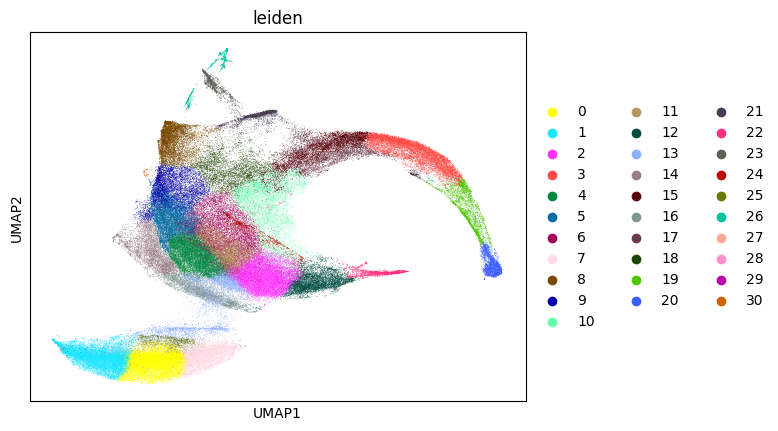

In [26]:
# find cell-type clusters
sc.pp.pca(
    cellproxy_adata, mask_var=cellproxy_adata.var_names.isin(svg), random_state=seed
)
sc.pp.neighbors(cellproxy_adata, random_state=seed)
sc.tl.umap(cellproxy_adata, min_dist=0.1, random_state=seed)
sc.tl.leiden(cellproxy_adata, resolution=1.5, random_state=seed)
sc.pl.umap(cellproxy_adata, color="leiden")

Once we have identified our cell-type clusters we can extract the cell type signatures and proceed as previously.

In [27]:
from sainsc.utils import celltype_signatures

signatures_denovo = celltype_signatures(cellproxy_adata[:, svg], celltype_col="leiden")

embryo.assign_celltype(signatures_denovo, log=True)

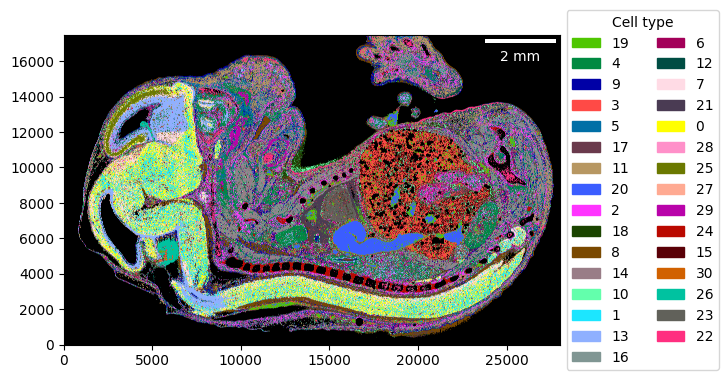

In [28]:
cmap_denovo = dict(
    zip(
        cellproxy_adata.obs["leiden"].cat.categories,
        cellproxy_adata.uns["leiden_colors"],
    )
)

_ = embryo.plot_celltype_map(cmap=cmap_denovo)

## Miscellaneous

### Analysing other spatial transcriptomics technologies

To analyse other technologies beside Stereo-seq such as imaging-based (e.g. Xenium) we only need to generate a [`sainsc.GridCounts`](#sainsc.GridCounts) or [`sainsc.LazyKDE`](#sainsc.LazyKDE) instance from a dataframe and then proceed as previously described. 
If the data is stored in GEM file format you can use the [`sainsc.io.read_gem_file`](#sainsc.io.read_gem_file) function to conveniently read the file and ensure the correct format. Other technologies, such as Xenium or Vizgen are already supported as well. Have a look at the [`sainsc.io`](#sainsc.io) module.

In case the technology/file format is not supported, we can manually prepare the data as shown below for the case of Xenium (obtained from [10x website](https://www.10xgenomics.com/datasets/fresh-frozen-mouse-brain-replicates-1-standard)).
The dataframe needs to contain a 'gene', 'x', and 'y' column. If a 'count' column is present it will be used otherwise a count of 1 (single transcript) will be assumed for each row. If the 'x' and 'y' columns are integers they will be assumed as indices of a square grid. Otherwise we can additionally define a bin size to use when instantiating the objects.

In [29]:
import polars as pl

xenium_file = Path("path/to/xenium/data") / "transcripts.csv.gz"
n_threads = 16

# Read xenium file, rename columns and filter blanks/controls
transcripts = (
    pl.read_csv(
        xenium_file,
        columns=["feature_name", "x_location", "y_location"],
        schema_overrides={"feature_name": pl.Categorical},
        n_threads=n_threads,
    )
    .rename({"feature_name": "gene", "x_location": "x", "y_location": "y"})
    .filter(~pl.col("gene").cast(pl.Utf8).str.contains("(BLANK|NegControl)"))
)

We can now generate a [`sainsc.GridCounts`](#sainsc.GridCounts) object from this `polars.DataFrame`. We will generate bins with a size of 500 nm.

In [30]:
from sainsc import GridCounts

xenium_counts = GridCounts.from_dataframe(
    transcripts, resolution=1000, binsize=0.5, n_threads=n_threads
)

print(xenium_counts)

GridCounts (16 threads)
    genes: 248
    shape: (20545, 14065)


Alternatively, we can directly generate a [`sainsc.LazyKDE`](#sainsc.LazyKDE) object. This has the additional benefit, that we can supply either a `polars.DataFrame` or a `pandas.DataFrame`. [`sainsc.GridCounts`](#sainsc.GridCounts) can only be generated from a `polars.DataFrame`.

In [31]:
from sainsc import LazyKDE

xenium = LazyKDE.from_dataframe(
    transcripts, resolution=1000, binsize=0.5, n_threads=n_threads
)

print(xenium)

LazyKDE (16 threads)
    genes: 248
    shape: (20545, 14065)
    resolution: 500.0 nm / px


### Visualizing genes

Some plotting functions allow for gene-specific plots instead of using the total mRNA.

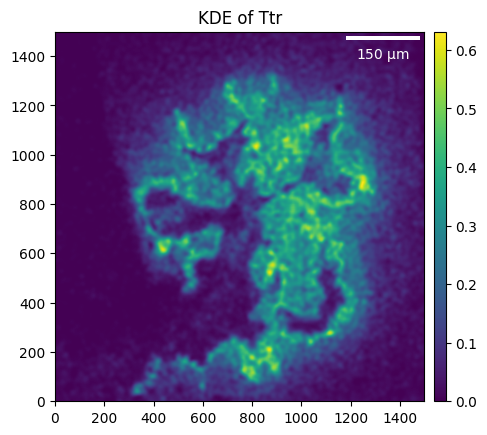

In [32]:
_ = embryo.plot_KDE(gene="Ttr", crop=((5_000, 6_500), (4_500, 6_000)))

### Cell type-specific thresholds

Background filtering support cell type-specific thresholding, this can be useful as the total mRNA in some cell types might be higher (especially when working with smaller gene panels such as from Xenium data).

In [33]:
kde_per_celltype = pd.DataFrame(
    {
        "kde": embryo.total_mRNA_KDE.flatten(),
        "celltype": pd.Categorical.from_codes(
            embryo.celltype_map.ravel(), categories=embryo.celltypes
        ),
    }
).dropna()

celltype_threshold = (
    kde_per_celltype.groupby("celltype", observed=True).median()["kde"] / 2
).to_dict()

min_t = 0.9

celltype_threshold = {
    ct: (t if t > min_t else min_t) for ct, t in celltype_threshold.items()
}

embryo.filter_background(celltype_threshold)

### Saving the analysis

Both, the [`sainsc.LazyKDE`](#sainsc.LazyKDE) and [`sainsc.GridCounts`](#sainsc.GridCounts) classes, can be serialized using the python [`pickle`](#pickle) module. This way you can always come back to where you left off.

In [34]:
import pickle

with open("my_analysis.pickle", "wb") as file:
    pickle.dump(embryo, file)